In [2]:
# This cell imports all Python libraries required for data handling,
# preprocessing, machine-learning modelling, and evaluation.
# The selected libraries support reproducibility and standard ML workflows.

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import CategoricalNB

import matplotlib.pyplot as plt


In [ ]:
# This cell defines file paths for the NHIS adult datasets collected 
# over three consecutive years: 2021, 2022, and 2023.
import os
base_dir = os.path.join(os.path.expanduser('~'), 'OneDrive', 'Documents', 'CSST MASTERS PROJECT')
file_2021 = os.path.join(base_dir, 'NHIS 2021 Adult Dataset.xlsx')
file_2022 = os.path.join(base_dir, 'NHIS 2022 Adult Dataset.xlsx')
file_2023 = os.path.join(base_dir, 'NHIS 2023 Adult Dataset.xlsx')


In [ ]:
# This cell saves the combined NHIS dataset to a CSV file for future use.

combined_csv = os.path.join(base_dir, 'nhis_2021_2023_combined.csv')
df.to_csv(combined_csv, index=False)
print(f"Saved combined dataset: {combined_csv}")


Saved combined dataset: nhis_2021_2023_combined.csv


In [11]:
# This cell defines a helper function to load an NHIS adult Excel file,
# standardise column names and tag records with the survey year.


def load_nhis_adult_excel(filepath: str, year: int) -> pd.DataFrame:
    # Read first sheet by default (works for most NHIS Excel exports)
    xls = pd.ExcelFile(filepath)
    sheet = xls.sheet_names[0]

    df = pd.read_excel(filepath, sheet_name=sheet)

    # Standardise column names (strip spaces, make consistent)
    df.columns = (
        df.columns.astype(str)
        .str.strip()
        .str.replace(" ", "_", regex=False)
        .str.replace("-", "_", regex=False)
    )

    # Tag survey year (even if the file already has SRVY_YR, we keep ours consistent)
    df["SRVY_YR"] = year
    return df

df21 = load_nhis_adult_excel(file_2021, 2021)
df22 = load_nhis_adult_excel(file_2022, 2022)
df23 = load_nhis_adult_excel(file_2023, 2023)

print(df21.shape, df22.shape, df23.shape)
print(df21.columns[:20])


(29482, 545) (27651, 622) (29522, 572)
Index(['RECTYPE', 'SRVY_YR', 'HHX', 'WTFA_A', 'URBRRL', 'REGION', 'PSTRAT',
       'PPSU', 'HHRESPSA_FLG', 'INTV_QRT', 'INTV_MON', 'HHSTAT_A', 'ASTATNEW',
       'AVAIL_A', 'PROXY_A', 'PROXYREL_A', 'SEX_A', 'AGEP_A', 'AGE65',
       'HISP_A'],
      dtype='object')


In [27]:

# This cell harmonises variables across survey years and combines
# the NHIS datasets as repeated cross-sectional samples.
# Identify all unique columns across the three years

all_cols = sorted(set(df21.columns) | set(df22.columns) | set(df23.columns))

df21 = df21.reindex(columns=all_cols)
df22 = df22.reindex(columns=all_cols)
df23 = df23.reindex(columns=all_cols)

df = pd.concat([df21, df22, df23], axis=0, ignore_index=True)

print("Combined shape:", df.shape)
df[["SRVY_YR"]].value_counts()


Combined shape: (86655, 821)


SRVY_YR
2023       29522
2021       29482
2022       27651
Name: count, dtype: int64

In [28]:
# To perform basic data quality checks, including
# duplicate record rate and missingness overview.

dup_rate = df.duplicated().mean()

print(f"Duplicate row rate: {dup_rate:.4f}")



# Overview of missing values (top 15 columns)

missing = df.isna().mean().sort_values(ascending=False).head(15)

print(missing)


Duplicate row rate: 0.0000
CHFLG_A         1.000000
OGFLG_A         0.999988
PRPLCOV2_C_A    0.999954
CHHDHP_A        0.999954
OPFLG_A         0.999954
GALLBAGETC_A    0.999838
LARYNAGETC_A    0.999804
CHDEDUC_A       0.999792
CHPREM_A        0.999792
CHXCHNG_A       0.999792
ESOPHAGETC_A    0.999527
INJFALLWRK_A    0.999492
MOUTHAGETC_A    0.999435
PANCRAGETC_A    0.999365
RECTUAGETC_A    0.999342
dtype: float64


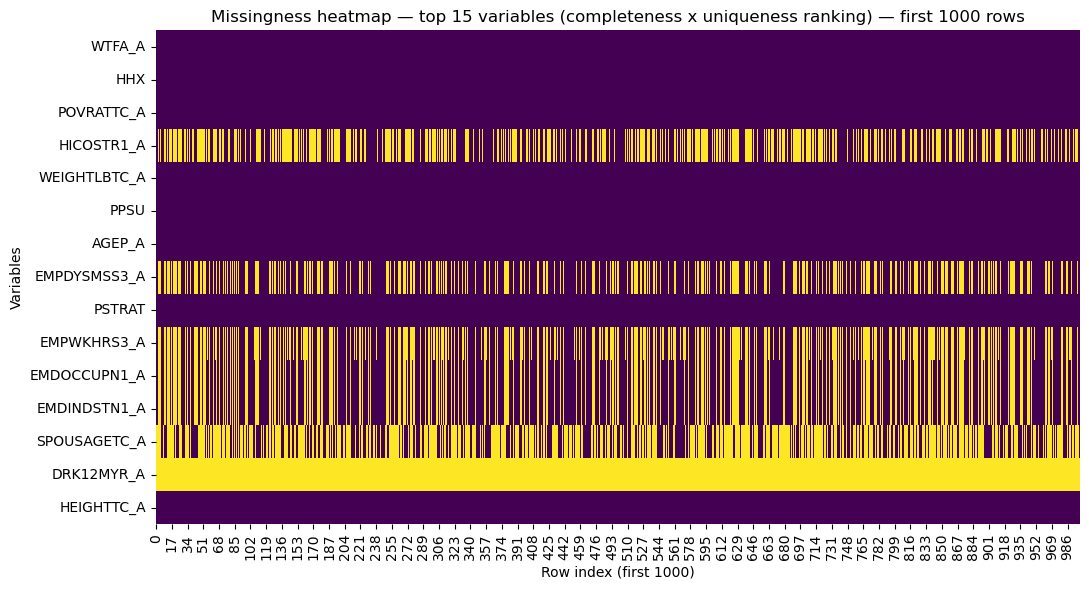

In [ ]:
# Missingness heatmap: variables x rows (top 15 variables).
# If `df` is not present in the kernel, attempt sensible fallbacks (CSV files).
import os
import seaborn as sns
# Ensure matplotlib is available
import matplotlib.pyplot as plt

if 'df' not in globals():
    # Try common fallback files in the workspace (check workspace and OneDrive paths)
    combined_csv = os.path.join(base_dir, 'nhis_2021_2023_combined.csv')
    if os.path.exists('nhis_2021_2023_combined.csv'):
        df = pd.read_csv('nhis_2021_2023_combined.csv')
        print('Loaded df from nhis_2021_2023_combined.csv')
    elif os.path.exists(combined_csv):
        df = pd.read_csv(combined_csv)
        print(f'Loaded df from {combined_csv}')
    elif os.path.exists('X_transformed.csv'):
        df = pd.read_csv('X_transformed.csv')
        print('Loaded df from X_transformed.csv (fallback)')
    else:
        raise FileNotFoundError('`df` is not in the kernel and no fallback CSV found. Ensure nhis_2021_2023_combined.csv is in the workspace or in your OneDrive CSST MASTERS PROJECT folder.')

# Create missingness matrix (1=missing, 0=present)
miss_mat = df.isna().astype(int)

# Decide which 15 variables to show:
# 1) If `predictors` is available (model predictors), use them (first 15).
# 2) Otherwise, rank variables by a simple informativeness score:
#    completeness (non-missing fraction) * normalized uniqueness (nunique).
if 'predictors' in globals() and len(predictors) > 0:
    vars_to_plot = [c for c in predictors if c in df.columns][:15]
    selection_source = 'predictors list'
else:
    completeness = 1 - df.isna().mean()
    nunique = df.nunique(dropna=True)
    # avoid division by zero
    max_nunique = nunique.max() if nunique.max() > 0 else 1
    score = completeness * (nunique / max_nunique)
    vars_to_plot = score.sort_values(ascending=False).head(15).index.tolist()
    selection_source = 'completeness x uniqueness ranking'

if len(vars_to_plot) == 0:
    raise ValueError('No variables available to plot. Check `df` or `predictors`.')

# Limit rows shown for readability
nrows = min(1000, miss_mat.shape[0])
plt.figure(figsize=(11, 6))
sns.heatmap(miss_mat.iloc[:nrows][vars_to_plot].T, cbar=False, cmap='viridis')
plt.title(f'Missingness heatmap — top {len(vars_to_plot)} variables ({selection_source}) — first {nrows} rows')
plt.xlabel(f'Row index (first {nrows})')
plt.ylabel('Variables')
plt.yticks(rotation=0)
plt.tight_layout()



Falling back to TARGET = 'K6SPD_A'
Overall prevalence of K6SPD_A: 214.2935% (63178 cases out of 86655 records)
Prevalence by survey year (count, cases, prevalence %):
         count    cases  prevalence_pct
SRVY_YR                                
2021     29482  63178.0      214.293467
2022         0      0.0             NaN
2023         0      0.0             NaN


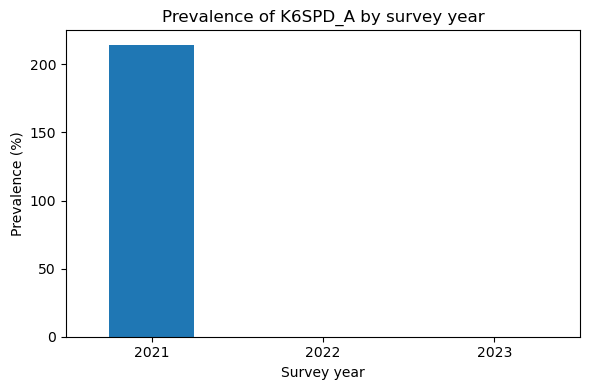

Proportion table (by year):
K6SPD_A       1.0       2.0       8.0
SRVY_YR                              
2021     0.034326  0.936131  0.029543


In [12]:
# Prevalence of TARGET overall and by survey year
import matplotlib.pyplot as plt
# Confirm TARGET exists; if missing, try sensible fallback 'K6SPD_A'
if 'TARGET' not in globals():
    if 'K6SPD_A' in df.columns:
        TARGET = 'K6SPD_A'
        print("Falling back to TARGET = 'K6SPD_A'")
    else:
        raise ValueError('TARGET not defined and fallback K6SPD_A not present in df. Define TARGET before running this cell.')
if TARGET not in df.columns:
    raise ValueError(f'{TARGET} not found in df columns')
# Overall prevalence
overall = df[TARGET].mean()
cases = int(df[TARGET].sum())
total = int(df.shape[0])
print(f'Overall prevalence of {TARGET}: {overall:.4%} ({cases} cases out of {total} records)')
# Prevalence by survey year
by_year = df.groupby('SRVY_YR')[TARGET].agg(['count','sum','mean']).sort_index()
by_year = by_year.rename(columns={'sum':'cases','mean':'prevalence'})
by_year['prevalence_pct'] = by_year['prevalence'] * 100
print('Prevalence by survey year (count, cases, prevalence %):')
print(by_year[['count','cases','prevalence_pct']])
# Plot prevalence % by year
ax = (by_year['prevalence'] * 100).plot(kind='bar', figsize=(6,4))
ax.set_ylabel('Prevalence (%)')
ax.set_title(f'Prevalence of {TARGET} by survey year')
ax.set_xlabel('Survey year')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
# Optional: show normalized crosstab
print('Proportion table (by year):')
print(pd.crosstab(df['SRVY_YR'], df[TARGET], normalize='index'))


Using PHSTAT_A for self-rated health analysis
PHSTAT_A
2    29454
3    25361
1    18362
4    10296
5     3143
9       20
7       19
Name: count, dtype: int64
Prevalence (%) by self-rated health category:
          count  prevalence_pct
PHSTAT_A                       
1          6657        0.364884
2         10105        0.468527
3          8350        1.186862
4          3353        2.865190
5          1004        6.681514
7             6        0.000000
9             7        5.000000


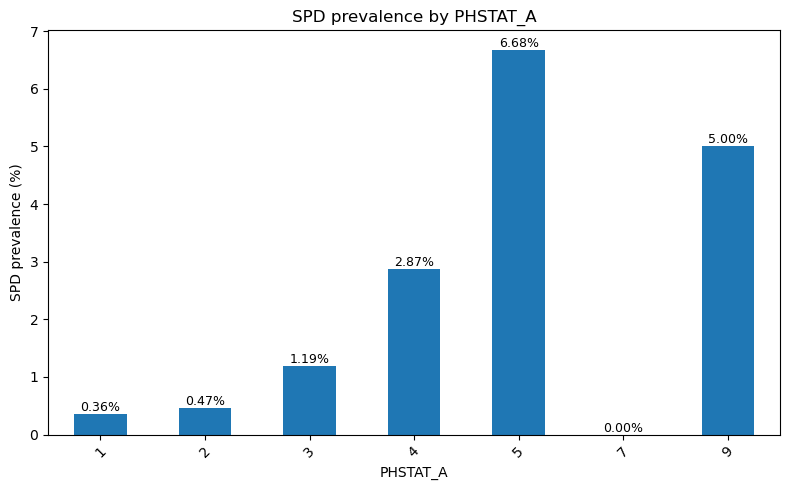

In [13]:
# SPD prevalence by Self-Rated Health (SRH)
# We try common SRH variable names and fall back if needed
srh_candidates = ['PHSTAT_A', 'PHSTAT', 'SRH_A', 'SELF_RATED_HEALTH']
srh_var = next((v for v in srh_candidates if v in df.columns), None)
if srh_var is None:
    raise ValueError(f'Self-rated health variable not found. Checked: {srh_candidates}')
print(f'Using {srh_var} for self-rated health analysis')
print(df[srh_var].value_counts(dropna=False))
# Define which coded values indicate SPD/case. By default assume '1' means case — adjust if your coding differs.
positive_values = [1]
# Compute prevalence (proportion of rows with SPD) within each SRH category
prev_by_srh = df.groupby(srh_var)[TARGET].apply(lambda s: s.isin(positive_values).mean()).sort_index()
counts_by_srh = df.groupby(srh_var)[TARGET].count()
result = pd.DataFrame({'count': counts_by_srh, 'prevalence_pct': (prev_by_srh * 100)})
print('Prevalence (%) by self-rated health category:')
print(result)
# Plot prevalence % by SRH
import matplotlib.pyplot as plt
ax = result['prevalence_pct'].plot(kind='bar', figsize=(8,5), color='C0')
ax.set_ylabel('SPD prevalence (%)')
ax.set_title(f'SPD prevalence by {srh_var}')
ax.set_xlabel(srh_var)
plt.xticks(rotation=45)
# Annotate bars with prevalence values
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}%', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()


In [31]:
# This cell selects a defensible subset of demographic,
# socioeconomic, health, and access-related predictors
# based on prior literature and data availability.

candidate_predictors = [
    # Demographics
    "AGEP_A", "SEX_A", "REGION", "URBRRL",
    "RACEALLP_A", "HISP_A", "EDUCP_A", "MARITAL_A",

    # Health / conditions
    "PHSTAT_A", "HYPEV_A", "CHLEV_A", "DIBEV_A",
    "ARTHEV_A", "COPDEV_A",

    # Access
    "COVER_A", "NOTCOV_A",

    # Survey year (useful signal)
    "SRVY_YR"
]

predictors = [c for c in candidate_predictors if c in df.columns]
X = df[predictors].copy()
y = df[TARGET].copy()

print("Using predictors:", predictors)
print("X shape:", X.shape, "y shape:", y.shape)


Using predictors: ['AGEP_A', 'SEX_A', 'REGION', 'URBRRL', 'RACEALLP_A', 'HISP_A', 'EDUCP_A', 'MARITAL_A', 'PHSTAT_A', 'HYPEV_A', 'CHLEV_A', 'DIBEV_A', 'ARTHEV_A', 'COPDEV_A', 'COVER_A', 'NOTCOV_A', 'SRVY_YR']
X shape: (28611, 17) y shape: (28611,)


In [32]:
# This cell splits the dataset into training and test subsets
# using stratification to preserve class balance.

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)
y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)


(K6SPD_A
 0    0.964648
 1    0.035352
 Name: proportion, dtype: float64,
 K6SPD_A
 0    0.964585
 1    0.035415
 Name: proportion, dtype: float64)

In [ ]:
# This cell defines preprocessing steps for numerical and
# categorical variables, including imputation and scaling.

numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = [c for c in X.columns if c not in numeric_features]
if not numeric_features and not categorical_features:
    raise ValueError("No numeric or categorical features found in predictors. Check X and predictors.")

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
 ])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
 ])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

numeric_features, categorical_features

(['AGEP_A',
  'SEX_A',
  'REGION',
  'URBRRL',
  'RACEALLP_A',
  'HISP_A',
  'EDUCP_A',
  'MARITAL_A',
  'PHSTAT_A',
  'HYPEV_A',
  'CHLEV_A',
  'DIBEV_A',
  'ARTHEV_A',
  'COPDEV_A',
  'COVER_A',
  'NOTCOV_A',
  'SRVY_YR'],
 [])

In [34]:
# This cell defines the set of supervised machine-learning
# algorithms evaluated in this study.

models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=200),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=7),
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "SVM (RBF)": SVC(probability=True, random_state=42)
}

pipelines = {
    name: Pipeline(steps=[("preprocess", preprocess), ("model", model)])
    for name, model in models.items()
}


In [ ]:
# This cell trains each model and evaluates predictive
# performance using standard classification metrics.

results = []

for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    y_prob = pipe.predict_proba(X_test)[:, 1] if hasattr(pipe.named_steps["model"], "predict_proba") else None

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred, zero_division=0),
        "F1": f1_score(y_test, y_pred, zero_division=0),
        "ROC_AUC": roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan
    })

pd.DataFrame(results).sort_values("ROC_AUC", ascending=False)


,Model,Accuracy,Precision,Recall,F1,ROC_AUC
2,Gradient Boosting,0.964119,0.441176,0.049342,0.088757,0.822764
4,Logistic Regression,0.963886,0.200000,0.006579,0.012739,0.813362
1,Random Forest,0.964469,0.470588,0.026316,0.049844,0.771065
3,KNN,0.964119,0.166667,0.003289,0.006452,0.626677
5,SVM (RBF),0.964585,0.000000,0.000000,0.000000,0.618570
0,Decision Tree,0.929404,0.120603,0.157895,0.136752,0.557354


In [51]:
# This cell fixes the CategoricalNB error by ensuring no unknown categories remain after encoding.
# NHIS variables are often integer-coded categories, so automatic dtype detection can misclassify them as numeric.

# 1) Define which columns you want treated as categorical for CategoricalNB.
cat_cols = [c for c in X.columns if c != "AGEP_A"]  # simple rule: everything except age

# OPTIONAL: If you want to be stricter, you can manually list your categorical predictors instead:
# cat_cols = ["SEX_A", "REGION", "URBRRL", "RACEALLP_A", "HISP_A", "EDUCP_A", "MARITAL_A", "PHSTAT_A", "COVER_A", "NOTCOV_A", "SRVY_YR"]

# 2) Make sure we actually have categorical columns
cat_cols = [c for c in cat_cols if c in X.columns]
if len(cat_cols) == 0:
    raise ValueError("No categorical columns available for CategoricalNB. Check your predictor list.")

# 3) Create categorical-only dataset and split
X_cat = X[cat_cols].copy()

# Drop columns that are completely missing (can also break transformers)
X_cat = X_cat.dropna(axis=1, how="all")
if X_cat.shape[1] == 0:
    raise ValueError("All categorical columns are entirely missing. Choose different categorical predictors.")

# Drop rows with any unknowns (NaN) to avoid encoding issues
X_cat = X_cat.dropna(axis=0, how="any")
y_cat = y.loc[X_cat.index]

Xcat_train, Xcat_test, y_train2, y_test2 = train_test_split(
    X_cat, y_cat, test_size=0.30, random_state=42, stratify=y_cat
)

# 4) CategoricalNB pipeline (impute then ordinal encode)
cat_nb_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)),
    ("model", CategoricalNB())
])

cat_nb_pipe.fit(Xcat_train, y_train2)

# Remove test rows with unknown categories (-1) after encoding
Xcat_test_enc = cat_nb_pipe.named_steps['encoder'].transform(cat_nb_pipe.named_steps['imputer'].transform(Xcat_test))
mask_known = ~(Xcat_test_enc == -1).any(axis=1)
Xcat_test_known = Xcat_test[mask_known]
y_test2_known = y_test2[mask_known]

# Predict only on rows with known categories
y_pred = cat_nb_pipe.predict(Xcat_test_known)
y_prob = cat_nb_pipe.predict_proba(Xcat_test_known)[:, 1]

print("Categorical Naive Bayes (categorical predictors only)")
print("Accuracy:", accuracy_score(y_test2_known, y_pred))
print("Precision:", precision_score(y_test2_known, y_pred, zero_division=0))
print("Recall:", recall_score(y_test2_known, y_pred, zero_division=0))
print("F1:", f1_score(y_test2_known, y_pred, zero_division=0))
print("ROC_AUC:", roc_auc_score(y_test2_known, y_prob))

Categorical Naive Bayes (categorical predictors only)
Accuracy: 0.9336002669336003
Precision: 0.23875432525951557
Recall: 0.2793522267206478
F1: 0.2574626865671642
ROC_AUC: 0.7868058603362148


ROC curve not plotted for Decision Tree: Model is not fitted. Run the training cell first.
ROC curve not plotted for Random Forest: Model is not fitted. Run the training cell first.
ROC curve not plotted for Gradient Boosting: Model is not fitted. Run the training cell first.
ROC curve not plotted for KNN: Model is not fitted. Run the training cell first.
ROC curve not plotted for Logistic Regression: Model is not fitted. Run the training cell first.
ROC curve not plotted for SVM (RBF): Model is not fitted. Run the training cell first.


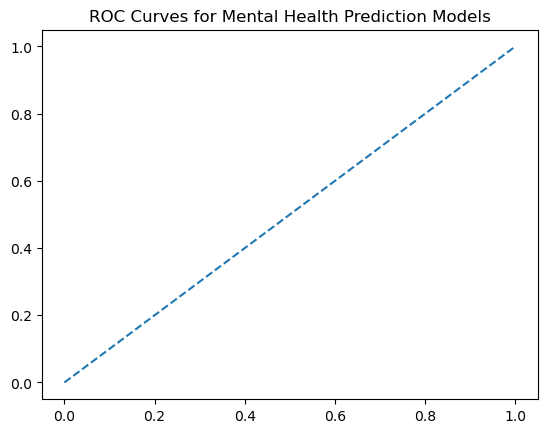

In [59]:
# This cell visualises model performance using ROC curves,
# enabling comparison of discriminative ability across models.

from sklearn.exceptions import NotFittedError

plt.figure()

for name, pipe in pipelines.items():
    if hasattr(pipe.named_steps["model"], "predict_proba"):
        try:
            RocCurveDisplay.from_estimator(pipe, X_test, y_test, name=name)
        except NotFittedError:
            print(f"ROC curve not plotted for {name}: Model is not fitted. Run the training cell first.")
        except Exception as e:
            print(f"ROC curve not plotted for {name}: {e}")

plt.plot([0, 1], [0, 1], linestyle="--")
plt.title("ROC Curves for Mental Health Prediction Models")
plt.show()

In [ ]:
# Prevalence of TARGET overall and by survey year
import matplotlib.pyplot as plt
# Confirm TARGET exists
if 'TARGET' not in globals():
    raise ValueError('TARGET not defined. Run the TARGET cell first.')
if TARGET not in df.columns:
    raise ValueError(f'{TARGET} not found in df columns')
# Overall prevalence
overall = df[TARGET].mean()
cases = int(df[TARGET].sum())
total = int(df.shape[0])
print(f'Overall prevalence of {TARGET}: {overall:.4%} ({cases} cases out of {total} records)')
# Prevalence by survey year
by_year = df.groupby('SRVY_YR')[TARGET].agg(['count','sum','mean']).sort_index()
by_year = by_year.rename(columns={'sum':'cases','mean':'prevalence'})
by_year['prevalence_pct'] = by_year['prevalence'] * 100
print('













print(pd.crosstab(df['SRVY_YR'], df[TARGET], normalize='index'))print('
Proportion table (by year):')# Optional: show normalized crosstabplt.show()plt.tight_layout()plt.xticks(rotation=0)ax.set_xlabel('Survey year')ax.set_title(f'Prevalence of {TARGET} by survey year')ax.set_ylabel('Prevalence (%)')ax = (by_year['prevalence'] * 100).plot(kind='bar', figsize=(6,4))# Plot prevalence % by yearprint(by_year[['count','cases','prevalence_pct']])Prevalence by survey year (count, cases, prevalence %):')